#**Explanation of script**

For the purpose of the individual assignment, the Colab model of "News Headline Sentiment with Small Language Model" is chosen for modifications and/or enhancements to be made to it.  The original model has the following features identified: (1) It is focused upon English content; (2) In respect of the models TextBlob and mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis model, the latter performs better with higher accuracy (0.7402284396940165 as opposed to 0.5210101645184952).

In the script below, modification is proposed to take into account the usage of Chinese news content, particularly relevant to analysis of financial news pertaining to the China / Hong Kong markets.  

*   The deep_translator library, which supports translation of multiple languages, is used and the Google Translator function is imported for present purposes.  The script is then loaded with the mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis model which has been proven to be a better and more accurate model for English content.  For Chinese content, the hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2 model is selected.  (See (1) to (3) below)
*   Using 9 sample texts with Chinese and English versions of the same / similar content, the texts are run against the Chinese and English models respectively.  It can be seen that the results by each models are not identical.  While for simple statements the results are the same (see index 0-4), for more complex expressions the native language model works better on the corresponding language (see index 5-8). (See (4) below)
*   In the Colab example, the existing data set in hf://datasets/zeroshot/twitter-financial-news-sentiment/ is ready-made based on English content with polarity scores in-built.  To cater for the present exercise, Chinese translation of the content is needed to test the Chinese model.  The whole data set contains around 10,000 texts; to simplify the process and for demonstration purpose, random selection of 10% is employed for English samples.  The same samples are then translated into Chinese.  Polarity scores have been adjusted from 0, 1, 2 to -1, 0, 1 for easier understanding.  (See (5) below)
*   The English model is applied to the original English samples.  (See (6) below)  The Chinese model is applied to the translated Chinese samples.  This is done for illustration purpose; better training is achieved by using formal original Chinese data set.  (See (7) below)  It is observed that the accuracy is not high using the models and comparing the same with the existing data (in fact, the English model performs poorer than the Colab example using prewritten data sheet showing results).  To give a picture of the matter, 10 random samples each of -1, 0, 1 are called.  A distribution table is also prepared to see whether the model tends to -1, 0 or 1 in its prediction as compared to the polarity marked in the existing data.  For the English version, it can be seen that positive polarity in existing data is substnatially classified more as neutral and the distribution tiltes to the negative polairty slightly.  For the Chinese version, even taking into account loss of content due to translation, a similar pattern is observed in terms of the clear tilting from positive to neutral classifications. This indicates that the model may be quite conservative in terms of polarity.
*   English news headlines are scrapped from https://finviz.com and Chinese news headlines are scrapped from http://www.aastocks.com/tc.  As example, HSBC is selected because it has both international and local presence, with more news in both English and Chinese.  Webscrapping script is updated to scrap content from the two internet sources and to present the news table accordingly.  I have used a previous assignment handed in for the AAStocks webscraping script to detect forward-looking news, with modifications here solely for illustration purpose (further fine-tuning of the script is necessary as the previous script was used to capture latest news as opposed to company-specific news based on search due to slighyly different webpage structure). (See (8) to (10) below)
*   The English and Chinese models in the script are applied to the content with results shown. (See (11) to (14) below)

The above changes can:

*   Use Chinese language model to predict sentiments of Chinese news content.
*   Provide for a basic understanding as to the tendency of the errors in using the models, whether inclined to -1, 0 or 1.
*   Provide for webscraping from Chinese financial news sources.

It is observed that the model is on the conservative side; and while the accuracy percentage is low, it is reasonable to conclude that a relatively sufficient positive polarity finding can be a supplementary indicator of upward momentum for the stock in light of the conservativeness of the model.  Further tuning of the model with more training data and repeat runs will help enhance the accuracy and reliability.

## **Result of running script based on 0.1% of original and translated training data from existing data set in hf://datasets/zeroshot/twitter-financial-news-sentiment/ from a test run on 1 March 2025**

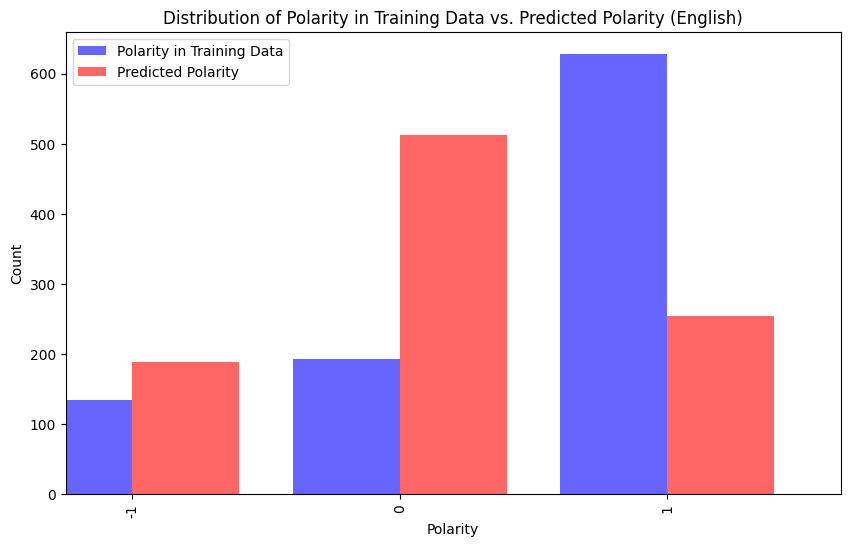

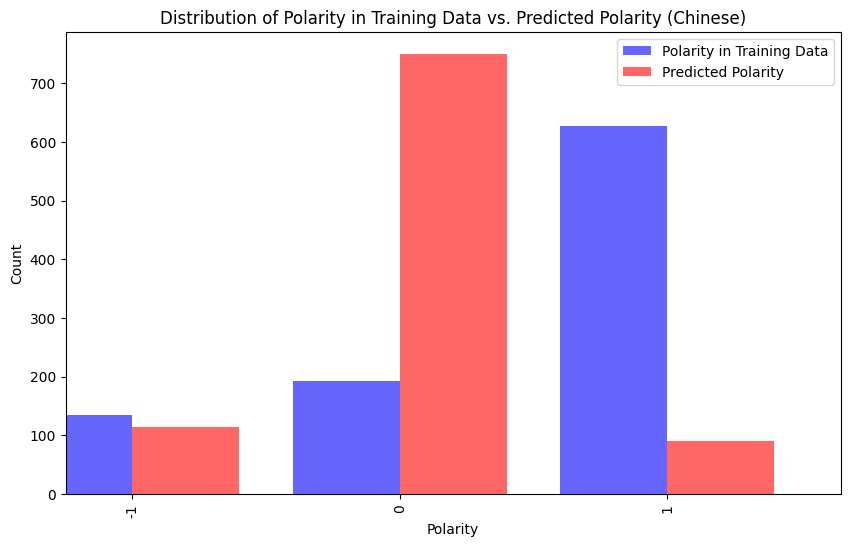








##**Script with modifications and/or enhancements**

In [1]:
#@title (1) Import libraries and helper functions

%pip install deep-translator playwright
!playwright install

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import requests, datetime, time
import pandas as pd
import numpy as np
from deep_translator import GoogleTranslator
from concurrent.futures import ThreadPoolExecutor
import random
from transformers import pipeline, BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification
import torch
import asyncio
import nest_asyncio
from playwright.async_api import async_playwright
from bs4 import BeautifulSoup as bs
import re
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

# Enable Google interactive table
from google.colab import data_table
data_table.enable_dataframe_formatter()

agent_info = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'}

# Convert the sentiment label
# from: { 0:Negative, 1:Neutral, 2:Positive}
#   to: {-1:Negative, 0:Neutral, 1:Positive}
def convertSentimentLabel(label):
  if label == 0: return -1
  elif label == 1: return 0
  else: return 1


Playwright Host validation warning: 
╔══════════════════════════════════════════════════════╗
║ Host system is missing dependencies to run browsers. ║
║ Missing libraries:                                   ║
║     libgtk-4.so.1                                    ║
║     libgraphene-1.0.so.0                             ║
║     libwoff2dec.so.1.0.2                             ║
║     libgstgl-1.0.so.0                                ║
║     libgstcodecparsers-1.0.so.0                      ║
║     libavif.so.13                                    ║
║     libharfbuzz-icu.so.0                             ║
║     libenchant-2.so.2                                ║
║     libsecret-1.so.0                                 ║
║     libhyphen.so.0                                   ║
║     libmanette-0.2.so.0                              ║
╚══════════════════════════════════════════════════════╝
    at validateDependenciesLinux (/usr/local/lib/python3.11/dist-packages/playwright/driver/package/lib/serv

In [2]:
#@title (2) Load the language model for Chinese content
tokenizer_zh = BertTokenizer.from_pretrained('hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2')
model_zh = BertForSequenceClassification.from_pretrained('hw2942/bert-base-chinese-finetuning-financial-news-sentiment-v2')

In [3]:
#@title (3) Load the language model for English content
tokenizer_en = AutoTokenizer.from_pretrained('mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis')
model_en = AutoModelForSequenceClassification.from_pretrained('mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis')

In [4]:
#@title (4) Quick comparison of the Chinese and English models with 9 sample texts

texts = [
    "这是一篇金融新闻的示例",
    "蘋果公司利潤增加了",
    "AAPL利潤增加了",
    "匯豐利潤減少了",
    "HSBC利潤減少了",
    "US Federal Reserve says inflation is high and further measures would be introduced",
    "美國聯儲局表示通脹高企, 並會推出額外措施",
    "China introduces further restrictions to regulate the Internet, causing market fall",
    "中國宣布進一步規管互聯網的限制措施, 導致市場下跌"
]
sentiment_labels = ['negative', 'neutral', 'positive']
def predict_sentiment(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_sentiment = torch.argmax(logits, dim=1).item()

    return sentiment_labels[predicted_sentiment]

predicted_labels_zh = [predict_sentiment(text, tokenizer_zh, model_zh) for text in texts]
predicted_labels_en = [predict_sentiment(text, tokenizer_en, model_en) for text in texts]

df_results = pd.DataFrame({
    'Text': texts,
    'Chinese Model Sentiment': predicted_labels_zh,
    'English Model Sentiment': predicted_labels_en
})

df_results

,Text,Chinese Model Sentiment,English Model Sentiment
0,这是一篇金融新闻的示例,neutral,neutral
1,蘋果公司利潤增加了,positive,neutral
2,AAPL利潤增加了,positive,neutral
3,匯豐利潤減少了,negative,neutral
4,HSBC利潤減少了,negative,neutral
5,US Federal Reserve says inflation is high and ...,neutral,negative
6,"美國聯儲局表示通脹高企, 並會推出額外措施",positive,neutral
7,China introduces further restrictions to regul...,neutral,negative
8,"中國宣布進一步規管互聯網的限制措施, 導致市場下跌",negative,neutral


In [5]:
#@title (5A) Creating sample English news data source with labelled sentiments polarity (-1: Negative, 0: Neutral, 1: Positive)
splits = {'train': 'sent_train.csv', 'validation': 'sent_valid.csv'}
df = pd.read_csv("hf://datasets/zeroshot/twitter-financial-news-sentiment/" + splits["train"])
df_1 = df.copy()
df_1['polarity'] = df_1['label'].apply(convertSentimentLabel)

sample_size = int(len(df_1) * 0.1)
sample_indices = random.sample(range(len(df_1)), sample_size)
df_sample_en = df_1.iloc[sample_indices].copy()

df_sample_en

,text,label,polarity
9518,Pyxus International among consumer gainers; Tu...,2,1
2066,$XOM $HES $CEO - Guyana aims for agreement wit...,2,1
8826,Should You Be Worried About ON Semiconductor C...,2,1
5352,Total : Résultats du quatrième trimestre et de...,2,1
3737,FirstFarms A/S (CPH:FFARMS) Delivered A Weaker...,0,-1
...,...,...,...
8601,How Large Is Activision Blizzard’s Mobile Gami...,2,1
2856,OSRAM Licht AG reports Q1 results,2,1
159,"$UBER $LYFT - Uber, Lyft can raise prices to p...",1,0
3380,"$LMNX - Luminex EPS beats by $0.08, beats on r...",1,0


In [6]:
#@title (5B) Creating sample Chinese news data source with labelled sentiments polarity (-1: Negative, 0: Neutral, 1: Positive)
translator = GoogleTranslator(source='auto', target='zh-CN')

def translate_text(text):
    return translator.translate(text)

df_sample_en_zh = df_sample_en.copy()
df_sample_en_zh['text_translated'] = df_sample_en_zh['text'].apply(translate_text)
df_sample_translated = df_sample_en_zh[['text_translated', 'polarity']]

df_sample_translated

,text_translated,polarity
9518,消费者赢得的pyxus国际；失败者中的特百惠品牌和化石,1
2066,美元,1
8826,您是否应该担心半导体公司（NASDAQ：ON）6.4％的权益回报率？,1
5352,总计：第四季度和2019年结果,1
3737,FirstFarms A/S（CPH：FFARMS）的ROE比其行业弱,-1
...,...,...
8601,Activision暴雪的移动游戏业务有多大？,1
2856,OSRAM LICHT AG报告Q1结果,1
159,$ UBER $ LYFT- UBER，LYFT可以将价格提高到利润-Barclays ht...,0
3380,$ LMNX -Luminex EPS击败$ 0.08，收入https://t.co/hrq...,0


In [7]:
#@title (5C) Saving samples for future use
df_sample_en.to_csv('df_sample_en(train).csv', index=False)
df_sample_translated.to_csv('df_sample_translated(train).csv', index=False)

In [8]:
#@title (6A) Use the English Language model to determine the sentiments of English original

sentiment_labels = [-1, 0, 1]
def predict_sentiment_en(text):
    inputs = tokenizer_en(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    outputs = model_en(**inputs)
    logits = outputs.logits
    predicted_sentiment_en = torch.argmax(logits, dim=1).item()
    return sentiment_labels[predicted_sentiment_en]

df_sample_en['text'].astype(str)
df_sample_en['predicted_polarity'] = df_sample_en['text'].apply(predict_sentiment_en)
df_sample_en

,text,label,polarity,predicted_polarity
9518,Pyxus International among consumer gainers; Tu...,2,1,1
2066,$XOM $HES $CEO - Guyana aims for agreement wit...,2,1,1
8826,Should You Be Worried About ON Semiconductor C...,2,1,1
5352,Total : Résultats du quatrième trimestre et de...,2,1,0
3737,FirstFarms A/S (CPH:FFARMS) Delivered A Weaker...,0,-1,1
...,...,...,...,...
8601,How Large Is Activision Blizzard’s Mobile Gami...,2,1,0
2856,OSRAM Licht AG reports Q1 results,2,1,0
159,"$UBER $LYFT - Uber, Lyft can raise prices to p...",1,0,1
3380,"$LMNX - Luminex EPS beats by $0.08, beats on r...",1,0,1


In [9]:
#@title (6B) Sample of errors (English)

accuracy = (df_sample_en['polarity'] == df_sample_en['predicted_polarity']).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

df_sample_en['correct'] = df_sample_en['predicted_polarity'] == df_sample_en['polarity']
sample_negative = df_sample_en[df_sample_en['predicted_polarity'] == -1].sample(10, random_state=42)
sample_neutral = df_sample_en[df_sample_en['predicted_polarity'] == 0].sample(10, random_state=42)
sample_positive = df_sample_en[df_sample_en['predicted_polarity'] == 1].sample(10, random_state=42)
def highlight_mismatch(row):
    color = 'background-color: red' if not row['correct'] else ''
    return [color] * len(row)
df_sampled_en1 = pd.concat([sample_negative, sample_neutral, sample_positive])
df_sampled_en1_styled = df_sampled_en1.style.apply(highlight_mismatch, axis=1)

df_sampled_en1_styled

Accuracy: 24.84%


,text,label,polarity,predicted_polarity,correct
6731,"Stocks, Bonds, & Dollar Stumble As Traders Reach 'Peak FOMO' https://t.co/P9454JXHmT",0,-1,-1,True
6218,"IMF Likely To Downgrade India’s Growth Forecast Significantly In January, Says Gita Gopinath",0,-1,-1,True
7485,The head of loan trading at UBS was terminated after engaging in an allegedly improper transaction https://t.co/3uMpB70a99,0,-1,-1,True
4719,Indonesia’s Jokowi Warns of Economic Calamity From Forest Fires,2,1,-1,False
3793,"The next downturn will be a ""smorgasbord recession,"" Paul Krugman said. https://t.co/YKmxl5IlL8",0,-1,-1,True
5358,Trump's Bi-Lat Trade Strategy Failed With China Deal (Podcast),2,1,-1,False
5795,WeWork sues SoftBank for backing out of $3bn deal https://t.co/l1e6iCiS0T,0,-1,-1,True
2958,Oil ends at its lowest level in more than a year as U.S. prices sink below $50 https://t.co/RcsR6VD6eg,0,-1,-1,True
6388,Probability of a recession pretty low: strategist,1,0,-1,False
1634,"Layoffs Loom as Canadian Rail Strike Hits Chemicals, Farmers",2,1,-1,False


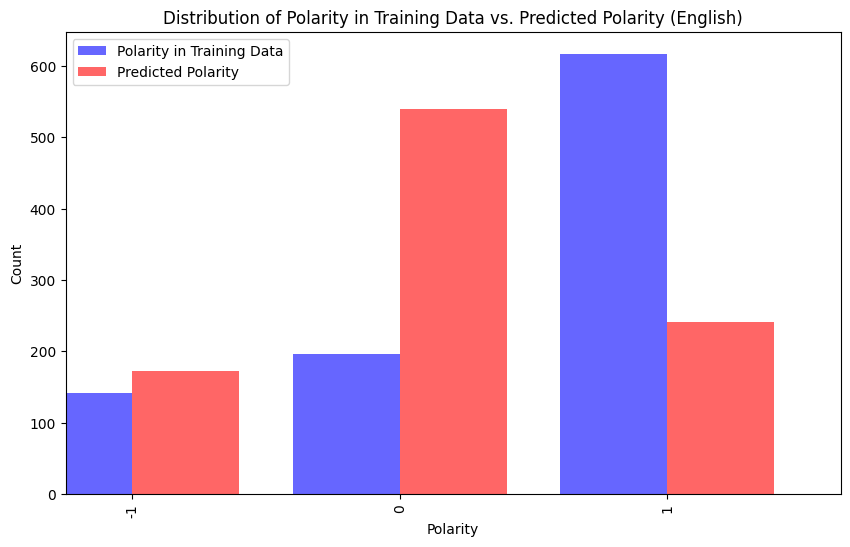

In [10]:
#@title (6C) Distribution of Polarity in Training Data vs. Predicted Polarity (English)

fig, ax = plt.subplots(figsize=(10, 6))
df_sample_en['polarity'].value_counts().sort_index().plot(kind='bar', color='blue', alpha=0.6, ax=ax, position=1, width=0.4, label='Polarity in Training Data')
df_sample_en['predicted_polarity'].value_counts().sort_index().plot(kind='bar', color='red', alpha=0.6, ax=ax, position=0, width=0.4, label='Predicted Polarity')
ax.set_xlabel('Polarity')
ax.set_ylabel('Count')
ax.set_title('Distribution of Polarity in Training Data vs. Predicted Polarity (English)')
ax.legend()
plt.show()

In [11]:
#@title (7A) Use the Chinese Language model to determine the sentiments of Chinese content

sentiment_labels = [-1, 0, 1]
def predict_sentiment_zh(text):
    inputs = tokenizer_zh(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    outputs = model_zh(**inputs)
    logits = outputs.logits
    predicted_sentiment_zh = torch.argmax(logits, dim=1).item()
    return sentiment_labels[predicted_sentiment_zh]

df_sample_translated['text_translated'] = df_sample_translated['text_translated'].astype(str)

df_sample_translated['predicted_polarity'] = df_sample_translated['text_translated'].apply(predict_sentiment_zh)

df_sample_translated



<ipython-input-11-eaf2b83cc741>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample_translated['text_translated'] = df_sample_translated['text_translated'].astype(str)
<ipython-input-11-eaf2b83cc741>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample_translated['predicted_polarity'] = df_sample_translated['text_translated'].apply(predict_sentiment_zh)


,text_translated,polarity,predicted_polarity
9518,消费者赢得的pyxus国际；失败者中的特百惠品牌和化石,1,-1
2066,美元,1,0
8826,您是否应该担心半导体公司（NASDAQ：ON）6.4％的权益回报率？,1,0
5352,总计：第四季度和2019年结果,1,0
3737,FirstFarms A/S（CPH：FFARMS）的ROE比其行业弱,-1,0
...,...,...,...
8601,Activision暴雪的移动游戏业务有多大？,1,1
2856,OSRAM LICHT AG报告Q1结果,1,0
159,$ UBER $ LYFT- UBER，LYFT可以将价格提高到利润-Barclays ht...,0,0
3380,$ LMNX -Luminex EPS击败$ 0.08，收入https://t.co/hrq...,0,0


In [12]:
#@title (7B) Sample of errors (Chinese)
accuracy = (df_sample_translated['polarity'] == df_sample_translated['predicted_polarity']).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")

df_sample_translated['correct'] = df_sample_translated['predicted_polarity'] == df_sample_translated['polarity']
sample_negative_zh = df_sample_translated[df_sample_translated['predicted_polarity'] == -1].sample(10, random_state=42)
sample_neutral_zh = df_sample_translated[df_sample_translated['predicted_polarity'] == 0].sample(10, random_state=42)
sample_positive_zh = df_sample_translated[df_sample_translated['predicted_polarity'] == 1].sample(10, random_state=42)

df_sample_translated1 = pd.concat([sample_negative_zh, sample_neutral_zh, sample_positive_zh])
df_sampled_translated1_styled = df_sample_translated1.style.apply(highlight_mismatch, axis=1)
df_sampled_translated1_styled

Accuracy: 23.58%


,text_translated,polarity,predicted_polarity,correct
8045,新闻6000股的1.60美元。股票下跌了80％，现在可以运行大,0,-1,False
8943,$ ctso（-18.9％PRE）细胞吸附剂（CTSO）暂时暂停其刷新2-AKI研究的入学... https://t.co/3aacitcwia,-1,-1,True
3011,当冠状病毒导致旅行限制https://t.co/f56q9fwr8e时，喷气燃料需求受到打击,-1,-1,True
3220,在伊朗军事领导人Qasem Soleimani在U中丧生之后，来自美国的石油工人将离开伊拉克。,1,-1,False
6689,标准普尔500分数较低,-1,-1,True
9102,特斯拉的股票下跌2.1％，在周三跌倒17.2％之后,-1,-1,True
22,$ shop- shopify失去公牛https://t.co/eoq7lchtk4,-1,-1,True
8417,布鲁克菲尔德资产管理失去了公牛,1,-1,False
7658,Tidjane Thiam的首席执行官辞职意味着瑞士信贷,1,-1,False
6667,纳斯达克复合材料下降0.2％,-1,-1,True


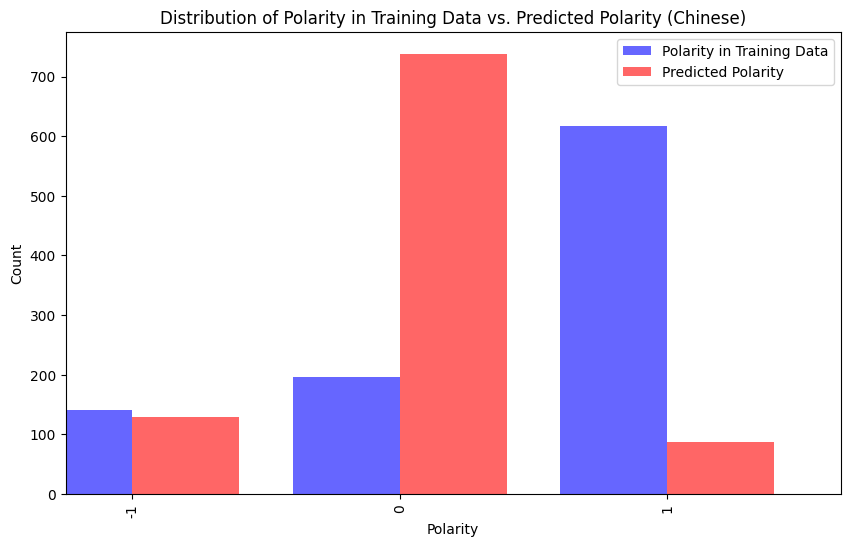

In [13]:
#@title (7C) Distribution of Polarity in Training Data vs. Predicted Polarity (Chinese)

fig, ax = plt.subplots(figsize=(10, 6))
df_sample_translated['polarity'].value_counts().sort_index().plot(kind='bar', color='blue', alpha=0.6, ax=ax, position=1, width=0.4, label='Polarity in Training Data')
df_sample_translated['predicted_polarity'].value_counts().sort_index().plot(kind='bar', color='red', alpha=0.6, ax=ax, position=0, width=0.4, label='Predicted Polarity')
ax.set_xlabel('Polarity')
ax.set_ylabel('Count')
ax.set_title('Distribution of Polarity in Training Data vs. Predicted Polarity (Chinese)')
ax.legend()
plt.show()

In [14]:
#@title (8) Select a stock ticker to get the URL for Webscraping (English + Chinese)

ticker = 'HSBC' # @param ["NVDA", "AAPL", "HSBC", "BABA"] {allow-input: true}
finviz_url = "https://finviz.com/quote.ashx?t="
AA_url = 'http://www.aastocks.com/tc/usq/quote/stock-news.aspx?symbol='

url_en = finviz_url + ticker
url_zh = AA_url + ticker

print(url_en)
print(url_zh)

https://finviz.com/quote.ashx?t=HSBC
http://www.aastocks.com/tc/usq/quote/stock-news.aspx?symbol=HSBC


In [15]:
# @title (9) Retrieving English news headlines

news_tables_en = {}
t_content_en = requests.get(url_en, headers = agent_info)
content_en_bs = bs(t_content_en.content, "html")
news_tab_en = content_en_bs.find(id="news-table")
news_tables_en[ticker] = news_tab_en

table_array_en = []

for name, news_table in news_tables_en.items():
    for x in news_table.findAll('tr'):
        try:
            # Headline
            text_content = x.a.get_text()
            # Dates
            date_content = x.td.text.split()

            if len(date_content) == 1:
                time = date_content[0]
            else:
                date = date_content[0]
                time = date_content[1]

            table_array_en.append([name, date, time, text_content])

        except:
            continue

table_array_en = list(set(tuple(row) for row in table_array_en))
table_news_en = pd.DataFrame(table_array_en, columns=["Ticker", "Date", "Time", "Headline"])
table_news_en['Date'] = np.where(table_news_en['Date'] == "Today", datetime.date.today(), table_news_en['Date'])
table_news_en['Date'] = pd.to_datetime(table_news_en['Date']).dt.date

table_news_en

<ipython-input-15-96f40f0c69a1>:12: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  for x in news_table.findAll('tr'):


,Ticker,Date,Time,Headline
0,HSBC,2025-02-25,04:30AM,HSBC to raise US$1.5 billion in perpetual conv...
1,HSBC,2025-01-22,07:04AM,HSBC bolsters wealth capabilities in India
2,HSBC,2024-12-05,06:33AM,HSBC appoints Lisa McGeough to lead US as CEO ...
3,HSBC,2024-12-09,05:51AM,HSBC India launches credit card for global pri...
4,HSBC,2025-02-18,11:08PM,HSBC sees $1.8 billion in revamp related costs...
...,...,...,...,...
95,HSBC,2025-02-13,04:30AM,HSBC cuts rates on fixed mortgages in Hong Kon...
96,HSBC,2025-01-28,03:46AM,HSBC plans biggest investment banking retrench...
97,HSBC,2024-12-18,05:00AM,HSBC Launches New Mortgage Assistance ProgramC...
98,HSBC,2025-02-20,11:23PM,Chinese Beverage Heiress Sued in Hong Kong Ove...


In [16]:
#@title (10) Retrieving Chinese news headlines

nest_asyncio.apply()

async def scrape_with_playwright(url_zh):
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()
        await page.goto(url_zh)

        previous_height = await page.evaluate('document.body.scrollHeight')
        while True:
            await page.evaluate('window.scrollTo(0, document.body.scrollHeight)')
            await page.wait_for_timeout(60000)
            new_height = await page.evaluate('document.body.scrollHeight')
            if new_height == previous_height:
                break
            previous_height = new_height

        content = await page.content()
        await browser.close()

    content_zh_bs = bs(content, 'html.parser')

    return content_zh_bs

bs_zh = asyncio.run(scrape_with_playwright(url_zh))
bs_zh


pattern_1 = re.compile(r'^newshead4 mar')
pattern_2 = re.compile(r'^clear mar')
pattern_3 = re.compile(r'\d{4}/\d{2}/\d{2} \d{2}:\d{2}')
separators = bs_zh.findAll('div', class_=pattern_2)

data_zh = []

start = separators[0]
content = ''
for sibling in start.next_siblings:
    if sibling in separators:
        break
    content += str(sibling)

title = start.find_next('div', class_=pattern_1).text if start.find_next('div', class_=pattern_1) else 'N/A'
source = start.find_next('span', class_='vw1200').text if start.find_next('span', class_='vw1200') else 'N/A'
recommended = start.find_next('div', class_='divRecommend').find('div', class_='value').string if start.find_next('div', class_='divRecommend').find('div', class_='value') else 'N/A'
positive = start.find_next('div', class_='divBullish').find('div', class_='value').string if start.find_next('div', class_='divBullish').find('div', class_='value') else 'N/A'
negative = start.find_next('div', class_='divBearish').find('div', class_='value').string if start.find_next('div', class_='divBearish').find('div', class_='value') else 'N/A'
data_zh.append({"Title": title, "Source": source, "Recommended by AASTOCKS users": recommended, "Found positive by AASTOCKS users": positive, "Found negative by AASTOCKS users": negative})

for i in range(len(separators) - 1):
    start = separators[i]
    end = separators[i + 1]
    content = ''
    for sibling in start.next_siblings:
        if sibling == end:
            break
        content += str(sibling)

    title = start.find_next('div', class_=pattern_1).text if start.find_next('div', class_=pattern_1) else print('N/A')
    source = start.find_next('span', class_='vw1200').text if start.find_next('span', class_='vw1200') else print('N/A')
    recommended = start.find_next('div', class_='divRecommend').find('div', class_='value').string if start.find_next('div', class_='divRecommend').find('div', class_='value') else print('N/A')
    positive = start.find_next('div', class_='divBullish').find('div', class_='value').string if start.find_next('div', class_='divBullish').find('div', class_='value') else print('N/A')
    negative = start.find_next('div', class_='divBearish').find('div', class_='value').string if start.find_next('div', class_='divBearish').find('div', class_='value') else print('N/A')
    data_zh.append({"Title": title, "Source": source, "Recommended by AASTOCKS users": recommended, "Found positive by AASTOCKS users": positive, "Found negative by AASTOCKS users": negative})

df_data_zh1 = pd.DataFrame(data_zh)
date_divs = bs_zh.find_all('div', class_=lambda x: x == 'inline_block')
data_dates = [div.text.strip() for div in date_divs if pattern_3.match(div.text.strip())]
data_dates
df_data_zh2 = pd.DataFrame(data_dates, columns=['Date'])
df_data_zh3 = pd.concat([df_data_zh1, df_data_zh2], axis=1)

def contains_keywords(text, keywords):
    pattern = '|'.join([f'{re.escape(keyword)}' for keyword in keywords])
    exact_match = bool(re.search(pattern, text))
    return exact_match

#Defining keywords

#Keywords suggesting events that took place immediately or shortly before publication of news
keywords_time = [
    '更新',
    '繼續',
    '後續',
    '最新',
    '短期內',
    '正',
    '仍',
    '截至',
    '將',
    '今',
    '昨',
    '即',
    '明'
]

#Keywords suggesting trend or movement that appeared immediately or shortly before publication of news
keywords_trend = [
    '走強',
    '走弱',
    '利好',
    '不利',
    '暴',
    '觀望',
    '有望',
    '期望',
    '急',
    '創',
    '累',
    '搶',
    '漲',
    '瀉',
    '破'
]

#Keywords suggesting action being taken by relevant entities immediately or shortly before publication of news
keywords_action = [
    '宣布',
    '公布',
    '發表',
    '會見',
    '記者會',
    '發布',
    '決定',
    '涉',
    '涉及',
    '推出',
    '回應',
    '增持',
    '減持',
    '沽',
    '維持',
    '聲明',
    '加息',
    '減息',
    '上調',
    '下調'
]

df_data_zh3['Keyword match (Time)'] = df_data_zh3['Title'].apply(lambda x: contains_keywords(x, keywords_time))
df_data_zh3['Keyword match (Trend)'] = df_data_zh3['Title'].apply(lambda x: contains_keywords(x, keywords_trend))
df_data_zh3['Keyword match (Action)'] = df_data_zh3['Title'].apply(lambda x: contains_keywords(x, keywords_action))

#To exclude '《阿思達克財經新聞》免責聲明 ' not being news and overwrite result
#Investigation into website shows that '《阿思達克財經新聞》免責聲明 ' pops up from time to time as latest news
df_data_zh3['Excluded from keyword search'] = df_data_zh3['Title'].str.contains('阿思達克財經新聞', '免責聲明')
df_data_zh3.loc[df_data_zh3['Excluded from keyword search'], ['Keyword match (Time)', 'Keyword match (Trend)', 'Keyword match (Action)']] = False

#Replacing True/False values with Yes/No
df_data_zh3[[
    'Keyword match (Time)',
    'Keyword match (Trend)',
    'Keyword match (Action)',
    'Excluded from keyword search']
] = df_data_zh3[[
    'Keyword match (Time)',
    'Keyword match (Trend)',
    'Keyword match (Action)',
    'Excluded from keyword search']
].replace({True: 'Yes', False: 'No'})

#Identifying forward-looking news based on keyword search result
df_data_zh3['Forward-looking news'] = df_data_zh3.apply(lambda row: 'Yes' if 'Yes' in
                             [row['Keyword match (Time)'],
                              row['Keyword match (Trend)'],
                              row['Keyword match (Action)']]
                             else 'No', axis=1)

#Rearranging order of columns
new_order = ['Title',
             'Date',
             'Source',
             'Forward-looking news',
             'Excluded from keyword search',
             'Keyword match (Time)',
             'Keyword match (Trend)',
             'Keyword match (Action)',
             'Recommended by AASTOCKS users',
             'Found positive by AASTOCKS users',
             'Found negative by AASTOCKS users']

df_data_zh4 = df_data_zh3[new_order]
df_data_zh4 = df_data_zh4.drop(0)
df_data_zh4 = df_data_zh4.reset_index(drop=True)
df_data_zh4

<ipython-input-16-7ba5be614941>:34: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  separators = bs_zh.findAll('div', class_=pattern_2)


,Title,Date,Source,Forward-looking news,Excluded from keyword search,Keyword match (Time),Keyword match (Trend),Keyword match (Action),Recommended by AASTOCKS users,Found positive by AASTOCKS users,Found negative by AASTOCKS users
0,\n匯豐私銀報告:37%中國內地企業家額外擁有香港居住權\n,2025/02/28 02:19 GMT,滙港資訊,No,No,No,No,No,17,19,17
1,\n匯豐已發行15億美元永久後償或有可轉換證券\n,2025/02/28 01:36 GMT,格隆匯新聞,No,No,No,No,No,17,22,15
2,\n滙控已發行15億美元永久後償或有可轉換證券\n,2025/02/28 00:38 GMT,AASTOCKS新聞,No,No,No,No,No,15,26,19
3,\n滙控昨共回購近583萬股 涉資共5.21億元\n,2025/02/28 00:29 GMT,AASTOCKS新聞,Yes,No,Yes,No,Yes,15,34,13
4,\n匯控(00005)已發行15億美元永久後償或有可轉換證券\n,2025/02/27 23:44 GMT,滙港資訊,No,No,No,No,No,7,15,11
...,...,...,...,...,...,...,...,...,...,...,...
289,匯豐與法巴就出售德國私人銀行業務達成協議,2024/09/23 07:37 GMT,格隆匯新聞,No,No,No,No,No,12,17,7
290,傳匯豐控股(00005)在港商業地產貸款違約達32億美元 激增4.56倍,2024/09/23 07:13 GMT,智通財經,No,No,No,No,No,15,17,9
291,法國巴黎銀行將收購匯豐在德國的私人銀行業務,2024/09/23 06:23 GMT,格隆匯新聞,Yes,No,Yes,No,No,7,10,2
292,滙控上周五共回購近871萬股 涉資6億元,2024/09/23 00:09 GMT,AASTOCKS新聞,Yes,No,No,No,Yes,16,33,10


In [17]:
#@title (11) Use the English model to determine the sentiments of English headlines
sentiment_labels = [-1, 0, 1]
table_news_en['polarity'] = table_news_en['Headline'].apply(predict_sentiment_en)
table_news_en

,Ticker,Date,Time,Headline,polarity
0,HSBC,2025-02-25,04:30AM,HSBC to raise US$1.5 billion in perpetual conv...,1
1,HSBC,2025-01-22,07:04AM,HSBC bolsters wealth capabilities in India,1
2,HSBC,2024-12-05,06:33AM,HSBC appoints Lisa McGeough to lead US as CEO ...,0
3,HSBC,2024-12-09,05:51AM,HSBC India launches credit card for global pri...,0
4,HSBC,2025-02-18,11:08PM,HSBC sees $1.8 billion in revamp related costs...,1
...,...,...,...,...,...
95,HSBC,2025-02-13,04:30AM,HSBC cuts rates on fixed mortgages in Hong Kon...,-1
96,HSBC,2025-01-28,03:46AM,HSBC plans biggest investment banking retrench...,-1
97,HSBC,2024-12-18,05:00AM,HSBC Launches New Mortgage Assistance ProgramC...,0
98,HSBC,2025-02-20,11:23PM,Chinese Beverage Heiress Sued in Hong Kong Ove...,-1


In [18]:
#@title (12) Use the Chinese model to determine the sentiments of Chinese headlines
sentiment_labels = [-1, 0, 1]
df_data_zh4['polarity'] = df_data_zh4['Title'].apply(predict_sentiment_zh)
df_data_zh4

,Title,Date,Source,Forward-looking news,Excluded from keyword search,Keyword match (Time),Keyword match (Trend),Keyword match (Action),Recommended by AASTOCKS users,Found positive by AASTOCKS users,Found negative by AASTOCKS users,polarity
0,\n匯豐私銀報告:37%中國內地企業家額外擁有香港居住權\n,2025/02/28 02:19 GMT,滙港資訊,No,No,No,No,No,17,19,17,0
1,\n匯豐已發行15億美元永久後償或有可轉換證券\n,2025/02/28 01:36 GMT,格隆匯新聞,No,No,No,No,No,17,22,15,0
2,\n滙控已發行15億美元永久後償或有可轉換證券\n,2025/02/28 00:38 GMT,AASTOCKS新聞,No,No,No,No,No,15,26,19,0
3,\n滙控昨共回購近583萬股 涉資共5.21億元\n,2025/02/28 00:29 GMT,AASTOCKS新聞,Yes,No,Yes,No,Yes,15,34,13,0
4,\n匯控(00005)已發行15億美元永久後償或有可轉換證券\n,2025/02/27 23:44 GMT,滙港資訊,No,No,No,No,No,7,15,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...
289,匯豐與法巴就出售德國私人銀行業務達成協議,2024/09/23 07:37 GMT,格隆匯新聞,No,No,No,No,No,12,17,7,1
290,傳匯豐控股(00005)在港商業地產貸款違約達32億美元 激增4.56倍,2024/09/23 07:13 GMT,智通財經,No,No,No,No,No,15,17,9,0
291,法國巴黎銀行將收購匯豐在德國的私人銀行業務,2024/09/23 06:23 GMT,格隆匯新聞,Yes,No,Yes,No,No,7,10,2,0
292,滙控上周五共回購近871萬股 涉資6億元,2024/09/23 00:09 GMT,AASTOCKS新聞,Yes,No,No,No,Yes,16,33,10,0


In [19]:
#@title (13) Sentiment Distribution (English)

df_pie_en = table_news_en.groupby('polarity').count().reset_index()
df_pie_en.rename(columns={'Headline' : 'count'}, inplace=True)
color_map = {1: 'green', -1: 'red', 0: 'blue'}
fig = px.pie(df_pie_en, values='count', names='polarity', title='Sentiment Distribution (English)',
             color='polarity', color_discrete_map=color_map)
fig.show()

In [20]:
#@title (14) Sentiment Distribution (Chinese)

df_pie_zh = df_data_zh4.groupby('polarity').count().reset_index()
df_pie_zh.rename(columns={'Title' : 'count'}, inplace=True)
color_map = {1: 'green', -1: 'red', 0: 'blue'}
fig = px.pie(df_pie_zh, values='count', names='polarity', title='Sentiment Distribution (Chinese)',
             color='polarity', color_discrete_map=color_map)
fig.show()


